# Ultimate Challenge 

## Part 1 - EDA

In [2]:
# import necessary modules
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load JSON file
logins = pd.read_json('logins.json')
logins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [4]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


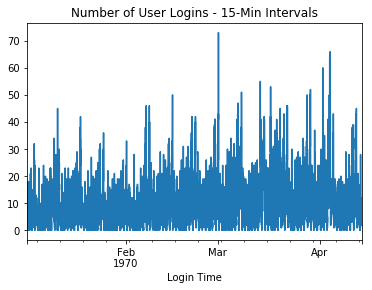

In [5]:
logins = logins.sort_values('login_time').set_index('login_time')
logins['count'] = 1
logins = logins.resample('15T').sum().fillna(0)
logins.plot(legend=False)
plt.title('Number of User Logins - 15-Min Intervals')
plt.xlabel('Login Time')
plt.show()

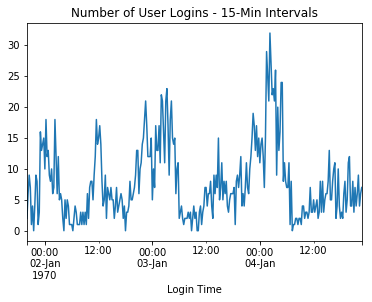

In [6]:
# too hard to see daily. Break it down.
logins.head(300).plot(legend=False)
plt.title('Number of User Logins - 15-Min Intervals')
plt.xlabel('Login Time')
plt.show()

Users login the most in the evening from about 8pm to 5am and around noon time from about 11am to 2pm. There are very few logins in the morning between 6am and 10am. We can double check and know the exact hour through a bar plot.

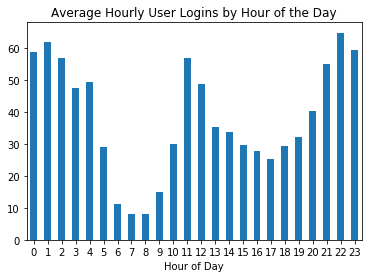

In [7]:
hourly_logins = logins.resample('1H').sum()
hourly_logins['hour'] = hourly_logins.index.hour
hourly_logins.groupby('hour').mean().plot(kind='bar', legend=False)
plt.title('Average Hourly User Logins by Hour of the Day')
plt.xlabel('Hour of Day')
plt.xticks(range(0,24), rotation=0)
plt.show()

This plot confirms what we saw originally. We can also look at the days/weeks instead of hours.

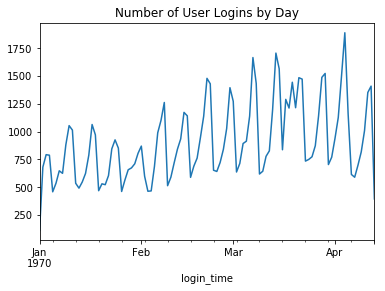

In [10]:
daily_logins = logins.resample('1D').sum()
daily_logins.plot(legend=False)
plt.title("Number of User Logins by Day")
plt.show()

Above graph shows a cyclical pattern over the weeks.

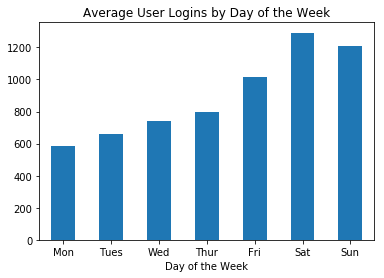

In [11]:
daily_logins['dayofweek'] = daily_logins.index.dayofweek
labels = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
ax = daily_logins.groupby('dayofweek')['count'].mean().plot(kind='bar', legend=False)
ax.set_xticklabels(labels, rotation=0)
plt.title('Average User Logins by Day of the Week')
plt.xlabel('Day of the Week')
plt.show()

Users login more on the weekends, particularly Saturday, than the weekdays.

## Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

_1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?_

Driver partners would be motivated to drive in both cities if their revenue goes up by doing so versus staying in their own respective cities. So, revenue would be the key measure of success of this experiment.

_2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:_

* how you will implement the experiment
* what statistical test(s) you will conduct to verify the significance of the
observation
* how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

Experiment: 
- Randomly split the participating drivers into two groups (make sure sample size is large)
    - control group: leaving everything the same as it is with the toll costs and letting the driver partners do their usual thing.
    - treatment group: reimburse all toll costs for at least a week and let them know they can freely drive between the cities, receiving profit in both Metropolis and Gotham

Statistical test:
- two sample t test on driver activities and revenue between control and treatment group

Interpretation:
- Most likely there will be increased revenue if the toll costs are reimbursed since the description hints at how driver partners in Gotham can't maximize their profits in Metropolis during the day time with the toll costs despite the high demand and vice versa. If the revenue is significantly greater, then the recommendation would be to implement a new policy where driver partners can freely go through the toll bridge without any costs. If not, then the recommendation would be to find more meaningful motivation than just toll cost reimbursement.

## Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [64]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set(style="darkgrid")

In [65]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [66]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [68]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [69]:
df[df.duplicated()]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
2608,6.25,5.0,5.0,1.0,Astapor,2014-01-19,iPhone,2014-01-18,0.0,1,True,0.0
18057,2.33,5.0,5.0,1.0,Astapor,2014-01-11,iPhone,2014-01-11,0.0,1,True,0.0
29601,8.08,5.0,NaN,1.0,Winterfell,2014-01-02,Android,2014-01-01,0.0,1,False,100.0
34641,1.44,5.0,NaN,1.0,Winterfell,2014-01-19,iPhone,2014-01-18,0.0,1,True,0.0
36627,3.54,5.0,5.0,1.0,Winterfell,2014-01-19,Android,2014-01-18,0.0,1,False,0.0
39601,0.00,5.0,5.0,1.0,Winterfell,2014-01-11,Android,2014-01-10,0.0,1,False,100.0
42025,0.01,5.0,NaN,1.0,Winterfell,2014-01-19,Android,2014-01-18,0.0,1,False,0.0
45416,3.06,5.0,5.0,1.0,Astapor,2014-01-20,iPhone,2014-01-20,0.0,1,False,100.0


In [70]:
# clean the data, drop null values in phone and duplicates; impute mean into the rest
def clean(data):
    data['avg_rating_by_driver'].fillna(data['avg_rating_by_driver'].mean(), inplace=True)
    data['avg_rating_of_driver'].fillna(data['avg_rating_of_driver'].mean(), inplace=True)
    
    data.dropna(axis='rows', how='any', subset=['phone'], inplace=True)
    
    data = data.drop_duplicates()
    
    return data

In [81]:
df = clean(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49596 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49596 non-null float64
avg_rating_by_driver      49596 non-null float64
avg_rating_of_driver      49596 non-null float64
avg_surge                 49596 non-null float64
city                      49596 non-null object
last_trip_date            49596 non-null datetime64[ns]
phone                     49596 non-null object
signup_date               49596 non-null datetime64[ns]
surge_pct                 49596 non-null float64
trips_in_first_30_days    49596 non-null int64
ultimate_black_user       49596 non-null bool
weekday_pct               49596 non-null float64
retention                 49596 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 5.0+ MB


In [72]:
print("% of Data Kept: ", 49596/50000*100)

% of Data Kept:  99.19200000000001


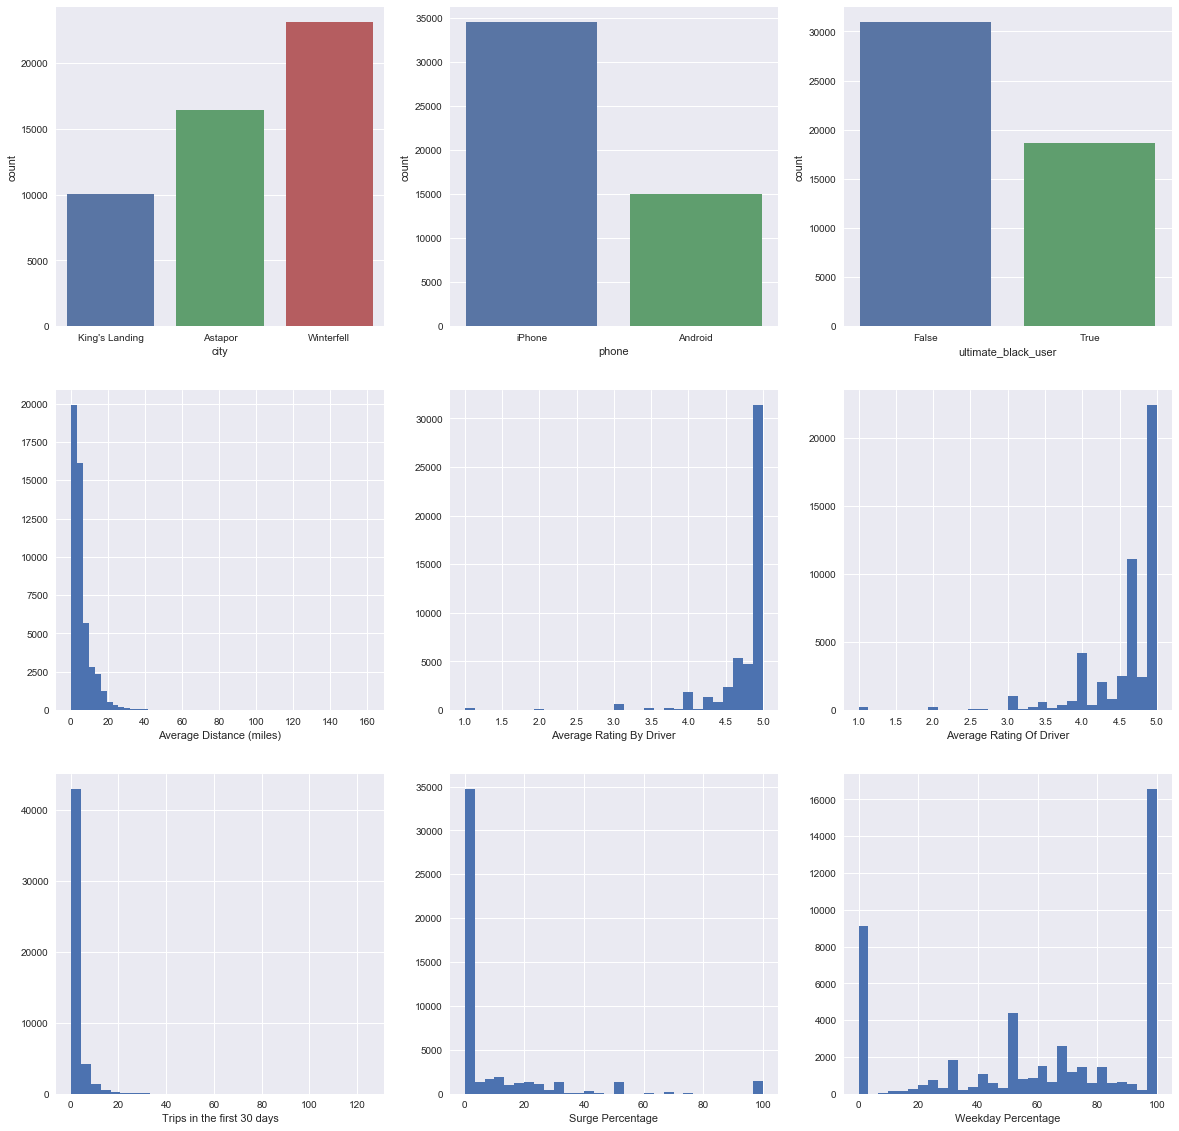

In [73]:
fig = plt.figure()

fig.set_size_inches(20, 20)

ax1 = fig.add_subplot(331)
ax1 = sns.countplot(x='city', data=df)

ax2 = fig.add_subplot(332)
ax2 = sns.countplot(x='phone', data=df)

ax3 = fig.add_subplot(333)
ax3 = sns.countplot(x='ultimate_black_user', data=df)

ax4 = fig.add_subplot(334)
ax4 = plt.hist(df.avg_dist, bins=50)
plt.xlabel("Average Distance (miles)")

ax5 = fig.add_subplot(335)
ax5 = plt.hist(df.avg_rating_by_driver, bins=30)
plt.xlabel("Average Rating By Driver")

ax6 = fig.add_subplot(336)
ax6 = plt.hist(df.avg_rating_of_driver, bins=30)
plt.xlabel("Average Rating Of Driver")

ax7 = fig.add_subplot(337)
ax7 = plt.hist(df.trips_in_first_30_days, bins=30)
plt.xlabel("Trips in the first 30 days")

ax8 = fig.add_subplot(338)
ax8 = plt.hist(df.surge_pct, bins=30)
plt.xlabel("Surge Percentage")

ax9 = fig.add_subplot(339)
ax9 = plt.hist(df.weekday_pct, bins=30)
plt.xlabel("Weekday Percentage")

plt.show()

In [74]:
def retentions(data):
    """
    Takes a dataframe
    Returns dataframe with retention column added
    """
    # get the most recent trip date
    from_day = max(data['last_trip_date'])
    # 30 days preciding the last trip date
    days = [from_day - datetime.timedelta(days=x) for x in range(0, 30)]
    # map functin to check if user is active in last 30 days
    data['retention'] = data['last_trip_date'].map(lambda x: int(x in days))
    return data

In [75]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [76]:
ret = retentions(df)
ret_rate = len(ret[ret['retention'] == 1])/len(ret)*100
print("% of users retained: " + str(ret_rate))

% of users retained: 36.65618195015727


### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [77]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retention
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


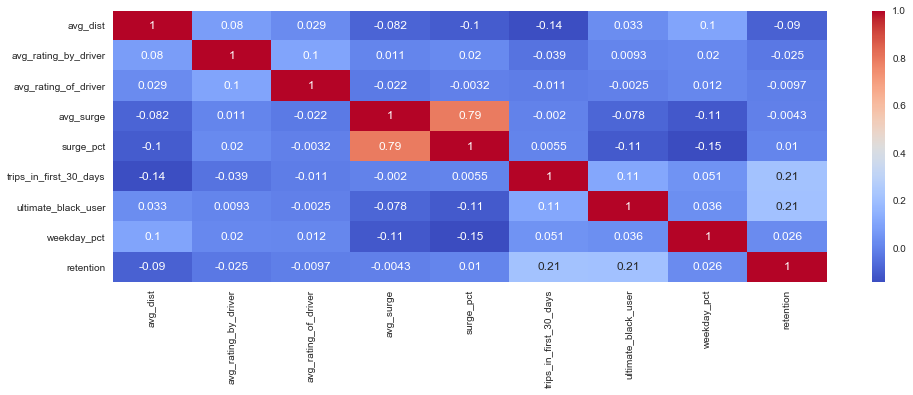

In [78]:
# find correlation
plt.figure(figsize = (16,5))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True)
plt.show()

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [115]:
X = df.drop(['retention','last_trip_date','signup_date','city','phone','ultimate_black_user'],axis=1)
y = df['retention']

dummy = pd.get_dummies(df[['city', 'phone', 'ultimate_black_user']], drop_first=True)
X = pd.concat([X, dummy], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [130]:
pipeline = Pipeline([
    ('classify', RandomForestClassifier())
])

param_grid = [
    {
        'classify__n_estimators': [5, 10, 50, 100, 200],
        'classify__max_features': ['auto', 'log2', None] 
    }
]

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3, n_jobs=1, refit=True)
grid.fit(X=X_train, y=y_train)
    
y_pred = grid.predict(X_test)

print()
print("Grid Search Attributes:", grid)
print("Best CV Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)
print("Test Data Accuracy Score:", accuracy_score(y_true=y_test, y_pred=y_pred))
print("Classification Report:\n", classification_report(y_true=y_test, y_pred=y_pred))


Grid Search Attributes: GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'classify__n_estimators': [5, 10, 50, 100, 200], 'classify__max_features': ['auto', 'log2', None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Best CV Score: 0.762376237624
Best Parameters: {'classify__max_features': None, 'classify__n_estimators': 200}
Test Data Accuracy Score: 0.759027311053
Classification Report:
   

In [126]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(n_jobs=-1)
clf.fit(X, y)

/Users/jkyung/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [118]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:, 1])
auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])

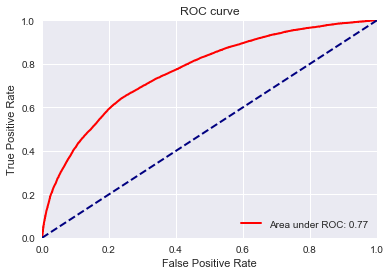

In [119]:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='Area under ROC: {:.2f}'.format(auc))
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.show()

In [120]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, clf.predict(X))
cm = cm/cm.sum(axis=1)
cm

array([[ 0.85771581,  0.24587459],
       [ 0.29271709,  0.49416942]])

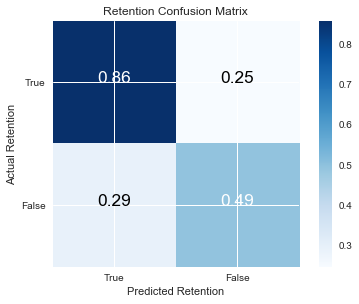

In [121]:
import itertools

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(2), ['True', 'False'])
plt.yticks(np.arange(2), ['True', 'False'])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment="center",
             fontsize='x-large',
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.title('Retention Confusion Matrix')
plt.ylabel('Actual Retention')
plt.xlabel('Predicted Retention')
plt.show()

In [124]:
list(zip(X.columns, clf.coef_[0]))

[('avg_dist', -0.03650387587367325),
 ('avg_rating_by_driver', -0.16035046519889062),
 ('avg_rating_of_driver', -0.05852419232488839),
 ('avg_surge', -0.1938941191635527),
 ('surge_pct', 0.004213417093508324),
 ('trips_in_first_30_days', 0.12203824988906561),
 ('weekday_pct', 0.001011870147828828),
 ('ultimate_black_user', 0.90671525787932927),
 ("city_King's Landing", 1.7722848975500269),
 ('city_Winterfell', 0.54358834759852004),
 ('phone_iPhone', 1.1474902951336288)]

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

Ultimate can use these models to find which features are more important in retention and use this model to predict which of their riders will remain engaged. They can take each feature and do something like a A/B test to see what improvements can be done and also for features that have no correlation, spend less time focusing on that. 